# Freaud detection project

With the rise of e-commerce platforms, businesses now process thousands to millions of online transactions daily. While this digital shift offers convenience, it also opens the door to fraudulent activities such as credit card theft, identity fraud, and money laundering.

This project aims to **detect fraudulent transactions** using machine learning techniques. By analyzing transaction details and geolocation data from IP addresses, we compute the **likelihood of a transaction being fraudulent**, helping businesses make smarter, real-time decisions.

We use two datasets:

* **Fraud\_Data.csv**: Contains transaction-level features and fraud labels.
* **IpAddress\_to\_Country.csv**: Maps IP address ranges to countries, enabling geographic insights.




In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from datetime import datetime
from datetime import tzinfo
from datetime import timezone

from sklearn.utils import class_weight

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [20]:
fraud_data = pd.read_csv('Fraud_Data.csv')
ip_data = pd.read_csv('IpAddress_to_Country.csv')

# EDA

In [21]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [22]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [23]:
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [24]:
ip_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [25]:
def transform_ip(arg) :
    try :
        return ip_data.country[(ip_data.lower_bound_ip_address < arg) & 
        (ip_data.upper_bound_ip_address > arg)].iloc[0]
        
    except IndexError :
        return "Unknown Country"

In [26]:
fraud_data['country_name'] = fraud_data['ip_address'].apply(transform_ip)

In [27]:
fraud_data.to_csv('fraud_data_de.csv', index = False)

In [28]:
# We'll need to convert *signup_time* and *purchase_time* columns in datetime format
fraud_data.loc[:, 'signup_time'] =  pd.to_datetime(fraud_data.loc[:, 'signup_time'], format='%Y-%m-%d %H:%M:%S')
fraud_data.loc[:, 'purchase_time'] =  pd.to_datetime(fraud_data.loc[:, 'purchase_time'], format='%Y-%m-%d %H:%M:%S')

In [29]:
sns.set(style="ticks", palette="pastel")

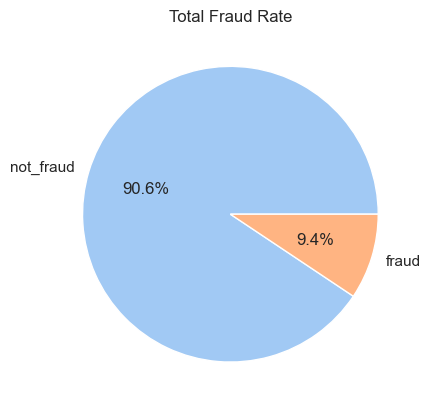

In [33]:
## fraud rate
plt.pie(fraud_data['class'].value_counts(), labels = ['not_fraud', 'fraud'], autopct='%1.1f%%')
plt.title("Total Fraud Rate")
plt.show()

C:\Users\ashra\AppData\Local\Temp\ipykernel_13892\1463402150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x  = purchase_value_discretized, y = fraud_data['class'], palette='viridis')


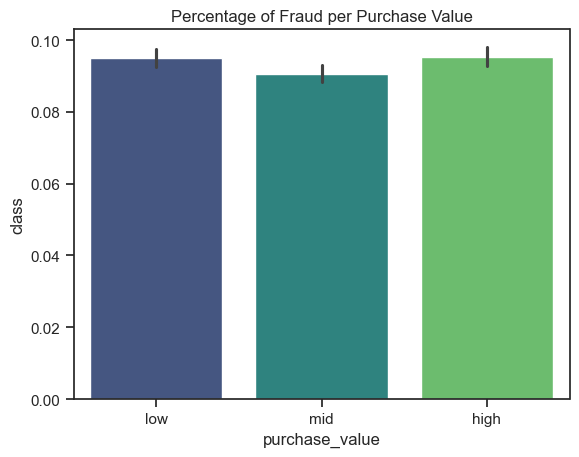

In [34]:
#  Purchase Value
purchase_value_discretized = pd.qcut(fraud_data['purchase_value'], 3, ['low','mid','high'])
sns.barplot( x  = purchase_value_discretized, y = fraud_data['class'], palette='viridis')
plt.title("Percentage of Fraud per Purchase Value")
plt.show()

C:\Users\ashra\AppData\Local\Temp\ipykernel_13892\3260993195.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = fraud_data, x  = 'source' , y = 'class', palette='inferno')


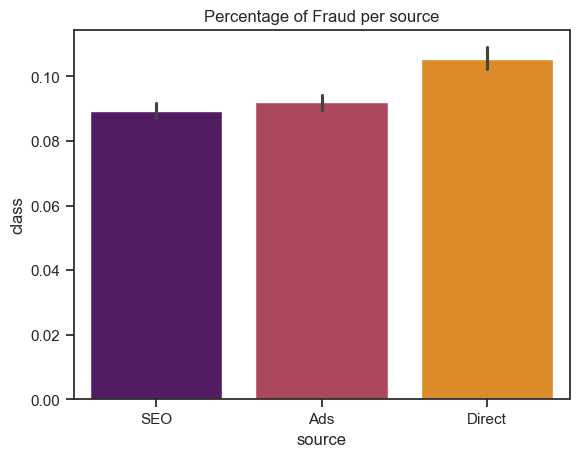

In [35]:
# source
sns.barplot(data = fraud_data, x  = 'source' , y = 'class', palette='inferno')
plt.title("Percentage of Fraud per source")
plt.show()

C:\Users\ashra\AppData\Local\Temp\ipykernel_13892\3528918153.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = fraud_data, x  = 'browser' , y = 'class', palette='magma')


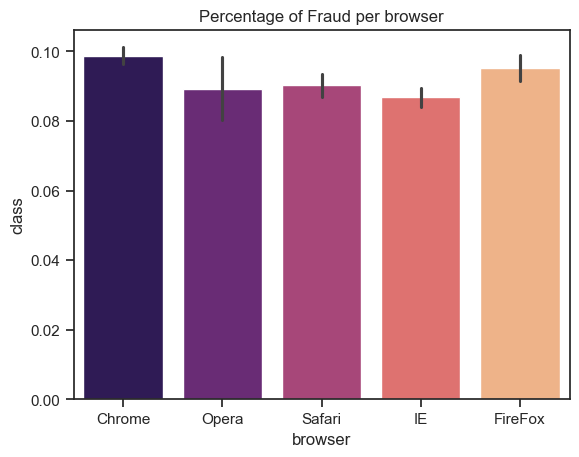

In [36]:
# browser
sns.barplot(data = fraud_data, x  = 'browser' , y = 'class', palette='magma')
plt.title("Percentage of Fraud per browser")
plt.show()

C:\Users\ashra\AppData\Local\Temp\ipykernel_13892\4027973316.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x  = age_discretized, y = fraud_data['class'], palette='plasma')


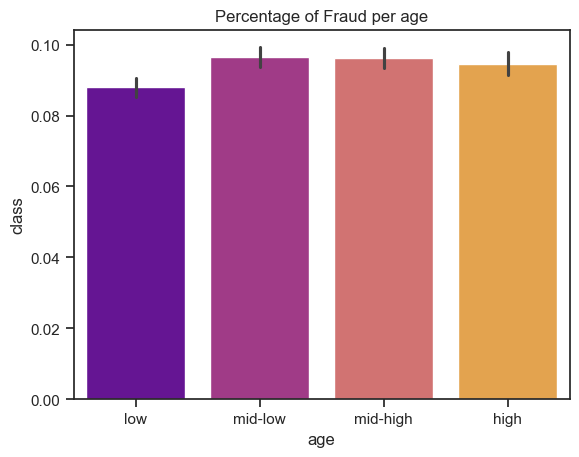

In [37]:
#  age
age_discretized = pd.qcut(fraud_data['age'], 4, ['low','mid-low', 'mid-high','high'])
sns.barplot( x  = age_discretized, y = fraud_data['class'], palette='plasma')
plt.title("Percentage of Fraud per age")
plt.show()

# Feature Engineering

In [38]:
fraud_data['country_name'].nunique()

182

In [39]:
fraud_data['country_name'].value_counts()

country_name
United States      58049
Unknown Country    21966
China              12038
Japan               7306
United Kingdom      4490
                   ...  
Myanmar                1
Vanuatu                1
Dominica               1
Niger                  1
Guadeloupe             1
Name: count, Length: 182, dtype: int64

In [40]:
fraud_data['country_name'].unique()

array(['Japan', 'United States', 'Unknown Country', 'Canada', 'China',
       'Brazil', 'India', 'Argentina', 'United Kingdom', 'South Africa',
       'Germany', 'Mexico', 'Sweden', 'Korea Republic of', 'Peru',
       'Portugal', 'Bangladesh', 'France',
       'Taiwan; Republic of China (ROC)', 'Russian Federation', 'Belgium',
       'Denmark', 'Netherlands', 'Iran (ISLAMIC Republic Of)', 'Spain',
       'Gabon', 'Saudi Arabia', 'Hong Kong', 'Georgia',
       'Syrian Arab Republic', 'Turkey', 'New Zealand', 'European Union',
       'Australia', 'Ukraine', 'Austria', 'Israel', 'Malaysia', 'Greece',
       'Italy', 'Norway', 'Poland', 'Venezuela', 'Thailand', 'Chile',
       'Morocco', 'Finland', 'Hungary', 'Indonesia', 'Colombia',
       'Ecuador', 'Lithuania', 'Switzerland', 'Viet Nam', 'Nigeria',
       'Egypt', 'Seychelles', 'Kazakhstan', 'Kenya',
       'Moldova Republic of', 'Trinidad and Tobago', 'Qatar', 'Bolivia',
       'Bulgaria', 'Romania', 'Croatia (LOCAL Name: Hrvatska)', '

In [41]:
country_fraud = fraud_data.groupby('country_name')['class'].agg({'mean','count'}).sort_values(by='mean', ascending = False)
country_fraud

,mean,count
country_name,,
Turkmenistan,1.000000,1
Namibia,0.434783,23
Sri Lanka,0.419355,31
Luxembourg,0.388889,72
Virgin Islands (U.S.),0.333333,3
...,...,...
Guadeloupe,0.000000,1
Gibraltar,0.000000,2
Ghana,0.000000,11


C:\Users\ashra\AppData\Local\Temp\ipykernel_13892\1421393752.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = data_countries, x = 'country_name', y = 'class', ax = ax, palette='rocket')


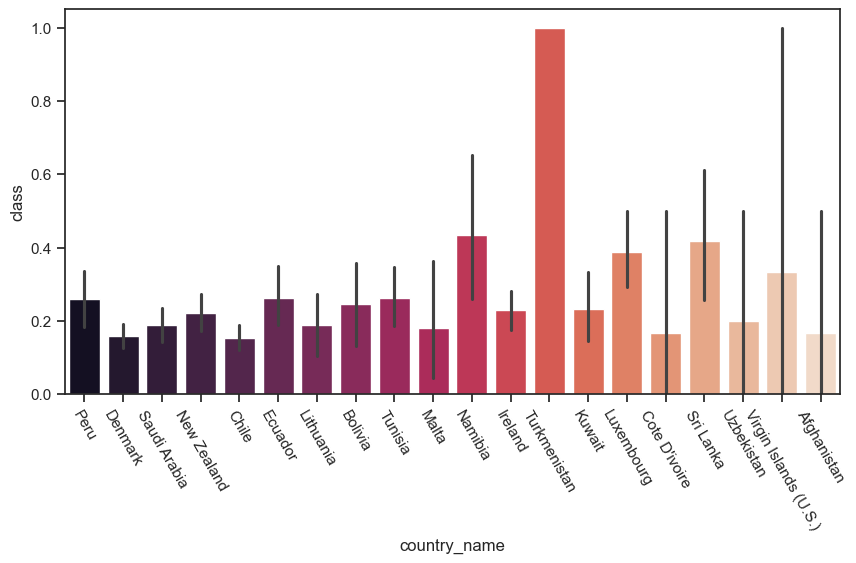

In [42]:
highest_20_countries = country_fraud.index[:20]
data_countries = fraud_data[fraud_data['country_name'].isin(highest_20_countries)]

fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(data = data_countries, x = 'country_name', y = 'class', ax = ax, palette='rocket')
ax.xaxis.set_tick_params(rotation=-60)

In [43]:
#device
df_device = fraud_data.groupby('device_id').agg({'device_id': 'count','class': np.mean})
df_device.columns = ['device_id_count', 'fraud_percentage']
df_device = df_device.sort_values(by = 'device_id_count', ascending = False)
df_device.head(15)

C:\Users\ashra\AppData\Local\Temp\ipykernel_13892\2019933898.py:2: FutureWarning: The provided callable <function mean at 0x000002337EB2A660> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_device = fraud_data.groupby('device_id').agg({'device_id': 'count','class': np.mean})


,device_id_count,fraud_percentage
device_id,,
KIPFSCNUGOLDP,20,0.950000
NGQCKIADMZORL,20,0.950000
CQTUVBYIWWWBC,20,0.950000
ITUMJCKWEYNDD,20,0.950000
EQYVNEGOFLAWK,20,0.950000
ZUSVMDEZRBDTX,20,0.950000
BWSMVSLCJXMCM,19,0.947368
IGKYVZDBEGALB,19,0.947368
EGLGSEGYPMMAM,19,0.947368


## It seems that the more a device_id makes purchases the more these purchases are likely to be fraudulents We suspect that these fraudulent purchases are made in a short window of time, probably by bots

In [44]:
fraud_data.loc[fraud_data['device_id'] == 'NGQCKIADMZORL',:].head(8)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
13973,278428,2015-01-03 13:10:40,2015-01-03 13:10:41,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
17397,53591,2015-01-03 13:10:43,2015-01-03 13:10:44,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
17551,384595,2015-01-03 13:10:35,2015-01-03 13:10:36,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
19324,181018,2015-01-03 13:10:41,2015-01-03 13:10:42,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
23254,226646,2015-01-03 13:10:51,2015-01-03 13:10:52,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
23670,381483,2015-01-03 13:10:49,2015-01-03 13:10:50,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
27888,277313,2015-01-03 13:10:45,2015-01-03 13:10:46,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
62937,186785,2015-01-03 13:10:52,2015-01-03 13:10:53,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand


### for the device NGQCKIADMZORL we can see a purchase made almost every second

In [45]:
device_count = fraud_data['device_id'].value_counts()
fraud_data['n_device_occur'] = fraud_data['device_id'].apply(lambda x : device_count[x] )

In [66]:
total_amount_perIP = fraud_data.groupby('ip_address')['purchase_value'].sum()
fraud_data['amount_purchase_per_ip'] = fraud_data['ip_address'].apply(lambda x: total_amount_perIP[x])
fraud_data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name,n_device_occur,amount_purchase_per_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,34
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,16
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,180
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown Country,1,44
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,39


In [67]:
data = fraud_data.copy()
to_remove = ['ip_address', 'device_id', 'user_id', 'purchase_value']
data = data[[c for c in data.columns if c not in to_remove  ]]

In [68]:
data.head(5)

,signup_time,purchase_time,source,browser,sex,age,class,country_name,n_device_occur,amount_purchase_per_ip
0,2015-02-24 22:55:49,2015-04-18 02:47:11,SEO,Chrome,M,39,0,Japan,1,34
1,2015-06-07 20:39:50,2015-06-08 01:38:54,Ads,Chrome,F,53,0,United States,1,16
2,2015-01-01 18:52:44,2015-01-01 18:52:45,SEO,Opera,M,53,1,United States,12,180
3,2015-04-28 21:13:25,2015-05-04 13:54:50,SEO,Safari,M,41,0,Unknown Country,1,44
4,2015-07-21 07:09:52,2015-09-09 18:40:53,Ads,Safari,M,45,0,United States,1,39


In [69]:
col_names = ['purchase_year', 'purchase_month', 'purchase_day', 'purchase_day_name' 'purchase_hour', 'purchase_min', 'purchase_sec']

In [70]:
# Convert 'signup_time' to datetime format
data['signup_time'] = pd.to_datetime(data['signup_time'], errors='coerce')

# Now you can access .dt attributes
data['signup_month'] = data['signup_time'].dt.month
data['signup_day'] = data['signup_time'].dt.day
data['signup_day_name'] = data['signup_time'].dt.day_name()

In [71]:
# Convert 'purchase_time' to datetime format
data['purchase_time'] = pd.to_datetime(data['purchase_time'], errors='coerce')

# Now you can access .dt attributes
data['purchase_month'] = data['purchase_time'].dt.month
data['purchase_day'] = data['purchase_time'].dt.day
data['purchase_day_name'] = data['purchase_time'].dt.day_name()

In [72]:
seconds_in_day = 24 * 60 * 60
to_remove = ['signup_time', 'purchase_time']

data['time_to_purchase'] = data['purchase_time'] - data['signup_time']

data['time_to_purchase'] = data['time_to_purchase'].dt.days * seconds_in_day + data['time_to_purchase'].dt.seconds

data['time_to_purchase'] = pd.qcut(data['time_to_purchase'], 10, labels = False, duplicates = 'drop')

data = data[[c for c in data.columns if c not in to_remove  ]] 

In [73]:
display(data.head(5))

,source,browser,sex,age,class,country_name,n_device_occur,amount_purchase_per_ip,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,time_to_purchase
0,SEO,Chrome,M,39,0,Japan,1,34,2,24,Tuesday,4,18,Saturday,4
1,Ads,Chrome,F,53,0,United States,1,16,6,7,Sunday,6,8,Monday,0
2,SEO,Opera,M,53,1,United States,12,180,1,1,Thursday,1,1,Thursday,0
3,SEO,Safari,M,41,0,Unknown Country,1,44,4,28,Tuesday,5,4,Monday,0
4,Ads,Safari,M,45,0,United States,1,39,7,21,Tuesday,9,9,Wednesday,4


In [74]:
print(data.columns)


Index(['source', 'browser', 'sex', 'age', 'class', 'country_name',
       'n_device_occur', 'amount_purchase_per_ip', 'signup_month',
       'signup_day', 'signup_day_name', 'purchase_month', 'purchase_day',
       'purchase_day_name', 'time_to_purchase'],
      dtype='object')


### Now it might be interesting to compute the amount of purchase over the time to purchase

In [76]:
data['purchase_over_time'] = 1000* data['amount_purchase_per_ip'] / data['time_to_purchase']

# Visulize Engineered Features

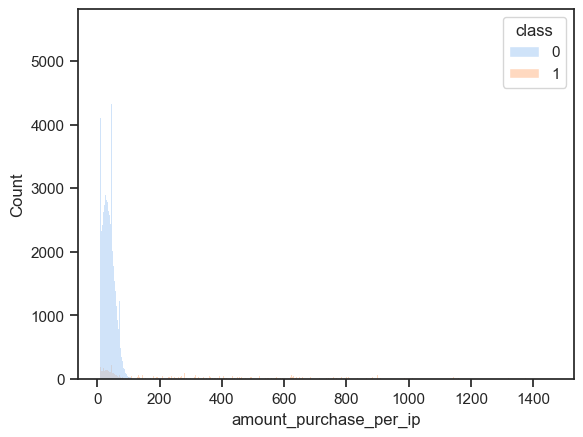

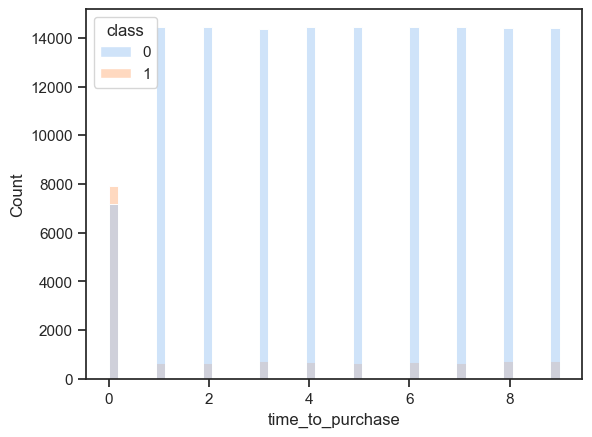

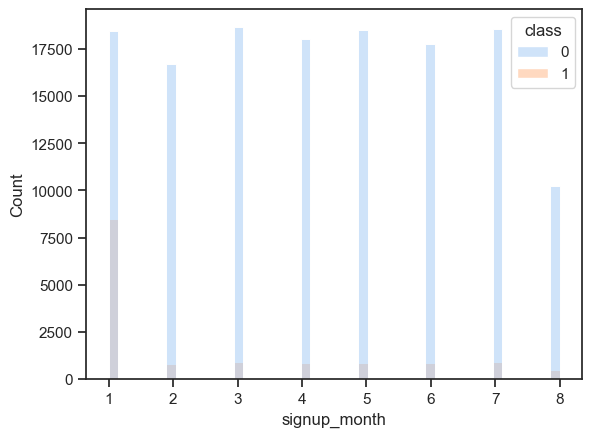

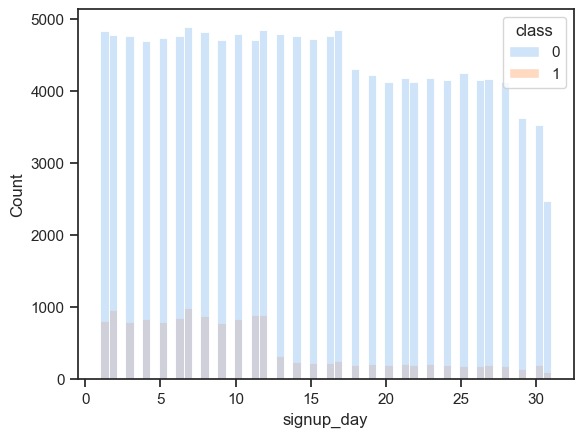

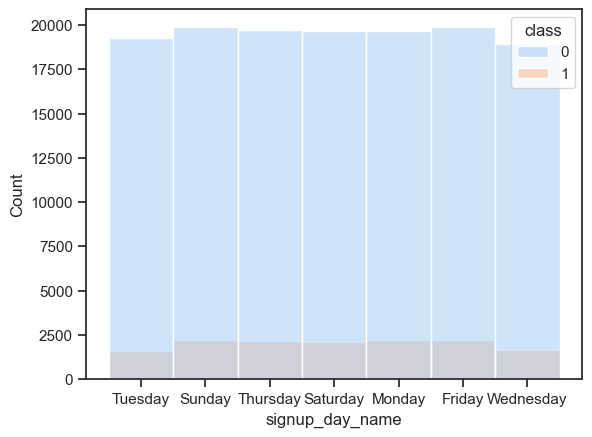

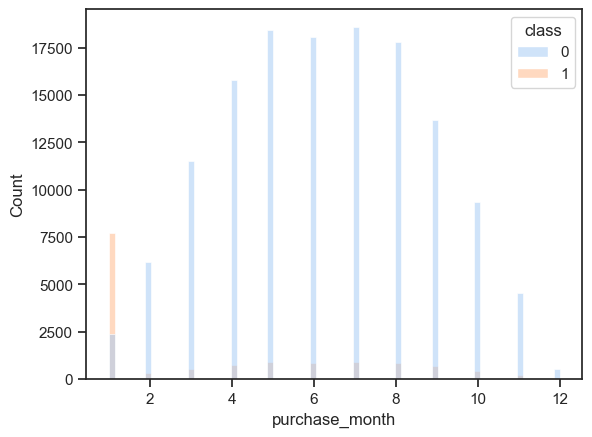

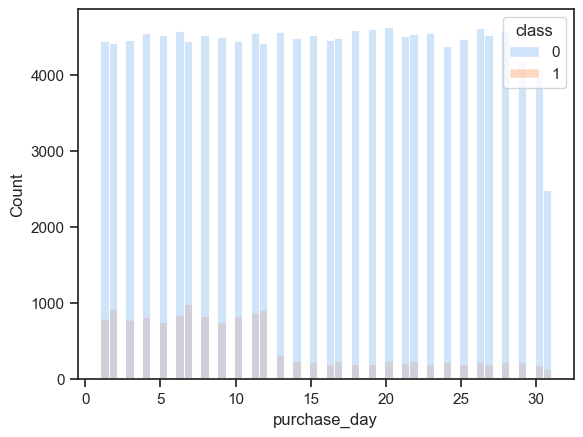

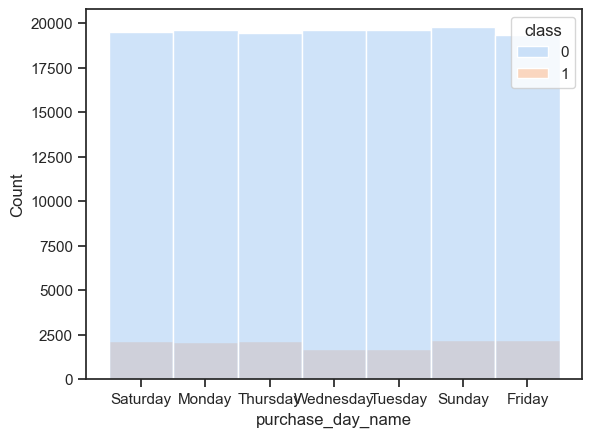

In [77]:
to_viz = ['amount_purchase_per_ip', 'time_to_purchase',	'signup_month',	'signup_day', 'signup_day_name', 'purchase_month', 'purchase_day',	'purchase_day_name']

for c in to_viz:
    plt.figure()
    sns.histplot(data = data, x = c , hue='class')
    plt.plot()

## Preprocessing

In [82]:
data

,source,browser,sex,age,class,country_name,n_device_occur,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,purchase_over_time
0,SEO,Chrome,M,39,0,Japan,1,2,24,Tuesday,4,18,Saturday,8.500000e+03
1,Ads,Chrome,F,53,0,United States,1,6,7,Sunday,6,8,Monday,inf
2,SEO,Opera,M,53,1,United States,12,1,1,Thursday,1,1,Thursday,inf
3,SEO,Safari,M,41,0,Unknown Country,1,4,28,Tuesday,5,4,Monday,inf
4,Ads,Safari,M,45,0,United States,1,7,21,Tuesday,9,9,Wednesday,9.750000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,SEO,Chrome,M,28,1,United States,2,1,27,Tuesday,3,29,Sunday,8.600000e+03
151108,SEO,Safari,M,32,0,Netherlands,1,5,15,Friday,5,26,Tuesday,3.500000e+04
151109,SEO,IE,F,26,0,Japan,1,3,3,Tuesday,5,20,Wednesday,6.666667e+03
151110,SEO,Chrome,M,37,0,United States,2,7,9,Thursday,9,7,Monday,9.200000e+03


In [81]:
# Drop columns in place
data.drop(columns=['time_to_purchase', 'amount_purchase_per_ip'], inplace=True)

KeyError: "['time_to_purchase', 'amount_purchase_per_ip'] not found in axis"

In [83]:
data.head(3)

,source,browser,sex,age,class,country_name,n_device_occur,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,purchase_over_time
0,SEO,Chrome,M,39,0,Japan,1,2,24,Tuesday,4,18,Saturday,8500.0
1,Ads,Chrome,F,53,0,United States,1,6,7,Sunday,6,8,Monday,inf
2,SEO,Opera,M,53,1,United States,12,1,1,Thursday,1,1,Thursday,inf


In [84]:
new_column_order = [col for col in data.columns if col != 'class'] + ['class']

In [85]:
data = data[new_column_order]

In [86]:
data

,source,browser,sex,age,country_name,n_device_occur,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,purchase_over_time,class
0,SEO,Chrome,M,39,Japan,1,2,24,Tuesday,4,18,Saturday,8.500000e+03,0
1,Ads,Chrome,F,53,United States,1,6,7,Sunday,6,8,Monday,inf,0
2,SEO,Opera,M,53,United States,12,1,1,Thursday,1,1,Thursday,inf,1
3,SEO,Safari,M,41,Unknown Country,1,4,28,Tuesday,5,4,Monday,inf,0
4,Ads,Safari,M,45,United States,1,7,21,Tuesday,9,9,Wednesday,9.750000e+03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,SEO,Chrome,M,28,United States,2,1,27,Tuesday,3,29,Sunday,8.600000e+03,1
151108,SEO,Safari,M,32,Netherlands,1,5,15,Friday,5,26,Tuesday,3.500000e+04,0
151109,SEO,IE,F,26,Japan,1,3,3,Tuesday,5,20,Wednesday,6.666667e+03,0
151110,SEO,Chrome,M,37,United States,2,7,9,Thursday,9,7,Monday,9.200000e+03,0


In [87]:
data.to_csv('output.csv', index=False)

In [88]:
data = pd.read_csv('output.csv')

In [89]:
data.head(3)

,source,browser,sex,age,country_name,n_device_occur,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,purchase_over_time,class
0,SEO,Chrome,M,39,Japan,1,2,24,Tuesday,4,18,Saturday,8500.0,0
1,Ads,Chrome,F,53,United States,1,6,7,Sunday,6,8,Monday,inf,0
2,SEO,Opera,M,53,United States,12,1,1,Thursday,1,1,Thursday,inf,1


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source              151112 non-null  object 
 1   browser             151112 non-null  object 
 2   sex                 151112 non-null  object 
 3   age                 151112 non-null  int64  
 4   country_name        151112 non-null  object 
 5   n_device_occur      151112 non-null  int64  
 6   signup_month        151112 non-null  int64  
 7   signup_day          151112 non-null  int64  
 8   signup_day_name     151112 non-null  object 
 9   purchase_month      151112 non-null  int64  
 10  purchase_day        151112 non-null  int64  
 11  purchase_day_name   151112 non-null  object 
 12  purchase_over_time  151112 non-null  float64
 13  class               151112 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 16.1+ MB


In [91]:
data['sex'] = data['sex'].astype(object)

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source              151112 non-null  object 
 1   browser             151112 non-null  object 
 2   sex                 151112 non-null  object 
 3   age                 151112 non-null  int64  
 4   country_name        151112 non-null  object 
 5   n_device_occur      151112 non-null  int64  
 6   signup_month        151112 non-null  int64  
 7   signup_day          151112 non-null  int64  
 8   signup_day_name     151112 non-null  object 
 9   purchase_month      151112 non-null  int64  
 10  purchase_day        151112 non-null  int64  
 11  purchase_day_name   151112 non-null  object 
 12  purchase_over_time  151112 non-null  float64
 13  class               151112 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 16.1+ MB


In [93]:
# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [94]:
# Optionally, drop rows with NaN values (or you could fill them with a strategy)
data.dropna(inplace=True)

In [95]:
data

,source,browser,sex,age,country_name,n_device_occur,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,purchase_over_time,class
0,SEO,Chrome,M,39,Japan,1,2,24,Tuesday,4,18,Saturday,8500.000000,0
4,Ads,Safari,M,45,United States,1,7,21,Tuesday,9,9,Wednesday,9750.000000,0
5,Ads,Chrome,M,18,Canada,1,5,21,Thursday,7,9,Thursday,10500.000000,0
6,Ads,Chrome,F,19,Unknown Country,1,8,1,Saturday,8,27,Thursday,5500.000000,0
7,Ads,Opera,M,34,United States,1,4,6,Monday,5,25,Monday,6750.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,SEO,Chrome,M,28,United States,2,1,27,Tuesday,3,29,Sunday,8600.000000,1
151108,SEO,Safari,M,32,Netherlands,1,5,15,Friday,5,26,Tuesday,35000.000000,0
151109,SEO,IE,F,26,Japan,1,3,3,Tuesday,5,20,Wednesday,6666.666667,0
151110,SEO,Chrome,M,37,United States,2,7,9,Thursday,9,7,Monday,9200.000000,0


In [96]:
# x = x.values
# y = np.array(y)

x = data.drop(columns=['class'])  # Features
y = data['class']                 # Target variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 59, stratify = y)

In [97]:
y

0         0
4         0
5         0
6         0
7         0
         ..
151107    1
151108    0
151109    0
151110    0
151111    0
Name: class, Length: 136000, dtype: int64

In [98]:
x

,source,browser,sex,age,country_name,n_device_occur,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,purchase_over_time
0,SEO,Chrome,M,39,Japan,1,2,24,Tuesday,4,18,Saturday,8500.000000
4,Ads,Safari,M,45,United States,1,7,21,Tuesday,9,9,Wednesday,9750.000000
5,Ads,Chrome,M,18,Canada,1,5,21,Thursday,7,9,Thursday,10500.000000
6,Ads,Chrome,F,19,Unknown Country,1,8,1,Saturday,8,27,Thursday,5500.000000
7,Ads,Opera,M,34,United States,1,4,6,Monday,5,25,Monday,6750.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,SEO,Chrome,M,28,United States,2,1,27,Tuesday,3,29,Sunday,8600.000000
151108,SEO,Safari,M,32,Netherlands,1,5,15,Friday,5,26,Tuesday,35000.000000
151109,SEO,IE,F,26,Japan,1,3,3,Tuesday,5,20,Wednesday,6666.666667
151110,SEO,Chrome,M,37,United States,2,7,9,Thursday,9,7,Monday,9200.000000


In [99]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136000 entries, 0 to 151111
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source              136000 non-null  object 
 1   browser             136000 non-null  object 
 2   sex                 136000 non-null  object 
 3   age                 136000 non-null  int64  
 4   country_name        136000 non-null  object 
 5   n_device_occur      136000 non-null  int64  
 6   signup_month        136000 non-null  int64  
 7   signup_day          136000 non-null  int64  
 8   signup_day_name     136000 non-null  object 
 9   purchase_month      136000 non-null  int64  
 10  purchase_day        136000 non-null  int64  
 11  purchase_day_name   136000 non-null  object 
 12  purchase_over_time  136000 non-null  float64
dtypes: float64(1), int64(6), object(6)
memory usage: 14.5+ MB


In [100]:
# Specify the indices of categorical columns (adjust these based on your dataset)
categorical_indices = [0, 1, 2, 4, 8, 11]  # Replace with actual indices

# Define the transformer to handle categorical columns
step1 = ColumnTransformer(
    transformers=[
        ('col_tnf', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_indices)
    ],
    remainder='passthrough'
)

# Define your model
step2 = LogisticRegression()

# Create the pipeline
pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

# Fit the pipeline on the training data
pipe.fit(x_train, y_train)

# Predict on the test set
y_pred = pipe.predict(x_test)
# Evaluate the model
print('R2 score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

R2 score: -0.05041598130406366
MAE: 0.04580882352941176


C:\Users\ashra\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ashra\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [101]:
# Predictions on sets
y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

C:\Users\ashra\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [103]:
import pickle

pickle.dump(data,open('raw_data.pkl','wb'))
pickle.dump(pipe,open('model.pkl','wb'))